In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
!curl ipinfo.io

{
  "ip": "35.229.113.51",
  "hostname": "51.113.229.35.bc.googleusercontent.com",
  "city": "North Charleston",
  "region": "South Carolina",
  "country": "US",
  "loc": "32.8546,-79.9748",
  "org": "AS15169 Google LLC",
  "postal": "29415",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}

In [2]:
(Xtrain,ytrain),(Xtest,ytest) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


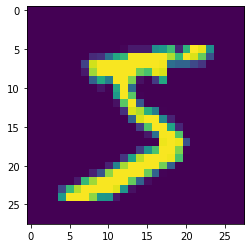

In [3]:
plt.imshow(Xtrain[0])

In [4]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#   print("Device:", tpu.master())
#   tf.config.experimental_connect_to_cluster(tpu)
#   tf.tpu.experimental.initialize_tpu_system(tpu)
#   strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#   strategy = tf.distribute.get_strategy()
# print("Number of replicas:", strategy.num_replicas_in_sync)
# AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

In [6]:
#here diag vector is the diagonal vector (top_left - bottom_right)
def Cosine2D(shape,diag=[-1,-1]):
  tempMat = np.indices(shape).swapaxes(0,2).swapaxes(0,1)
  m, n = [(ss - 1.) / 2. for ss in shape]
  tempMat = tempMat - np.array([m,n])
  #adding small epsilon value for avoiding errors while dividing
  tempMat = tempMat + 1e-10
  #finding dot product with diag direction for all
  magnitude = np.sqrt(np.square(tempMat[:,:,0:1]) + np.square(tempMat[:,:,1:]))
  unitTempMat = tempMat/magnitude

  #converting diagonal vector to unit vector
  diag = np.array(diag)
  diag = diag / math.sqrt(diag[0]**2 + diag[1]**2)

  return (np.dot(unitTempMat,diag)+1)/2


In [7]:
def patch_generator(shape,diag=[-1,-1],sigma=1):

  cosin_patch = Cosine2D(shape,diag)
  gauss_patch = gaussian2D(shape,sigma)

  return cosin_patch*gauss_patch

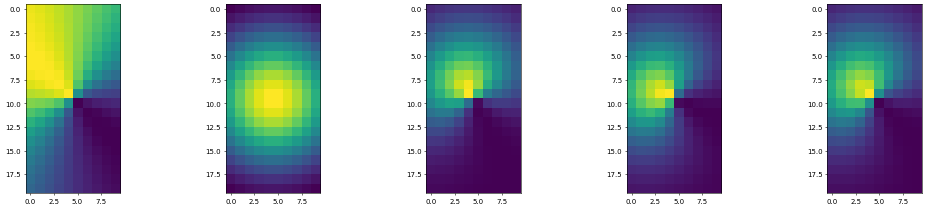

In [8]:
plt.figure(1,figsize = (25,5),dpi=50)
plt.subplot(151)
plt.imshow(Cosine2D((20,10)))
plt.subplot(152)
plt.imshow(gaussian2D((20,10),sigma=5))
plt.subplot(153)
plt.imshow(patch_generator((20,10),diag=[-2,-1],sigma=5))
plt.subplot(154)
plt.imshow(patch_generator((20,10),diag=[-1,-2],sigma=5))
plt.subplot(155)
plt.imshow(patch_generator((20,10),diag=[-1,-1],sigma=5))
plt.show()

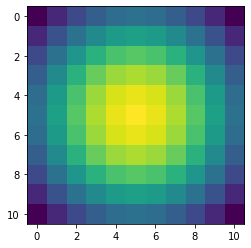

In [9]:
plt.imshow(gaussian2D((11,11),sigma=5))

In [10]:
training_samples = 2000

def find_coords(img):
  map = np.argwhere(img>10)
  xmin = map[:,0].min()
  xmax = map[:,0].max()
  ymin = map[:,1].min()
  ymax = map[:,1].max()
  return (xmin,ymin,xmax,ymax)

imgSize = 224
GaussianSigmaVal = 5
train_X,train_y = np.zeros((training_samples,imgSize,imgSize)),np.zeros((training_samples,2,imgSize,imgSize,1))
true_y = np.zeros((training_samples,4),dtype='int')
indices = np.random.randint(1,Xtrain.shape[0],size=training_samples)
for i in range(training_samples):
  index = indices[i]
  img = Xtrain[index]
  z = 5*np.random.rand()
  img = cv2.resize(img,(int(28*(1+z)),int(28*(1+z))))
  (h,w) = img.shape
  #Horizontal shift and vertical shifts
  hs = np.random.randint(10,imgSize-h-10)
  vs = np.random.randint(10,imgSize-w-10)
  train_X[i,hs:hs+h,vs:vs+w] = img
  bbox = find_coords(train_X[i])
  # print(train_y[i,bbox[0]-5:bbox[0]+5,bbox[1]-5:bbox[1]+5,0].shape)
  train_y[i,0,bbox[0]-5:bbox[0]+6,bbox[1]-5:bbox[1]+6,0] = patch_generator((11,11),sigma=GaussianSigmaVal,diag=[-1,-1])
  train_y[i,1,bbox[2]-5:bbox[2]+6,bbox[3]-5:bbox[3]+6,0] = patch_generator((11,11),sigma=GaussianSigmaVal,diag=[1,1])
  true_y[i,:] = bbox[:]


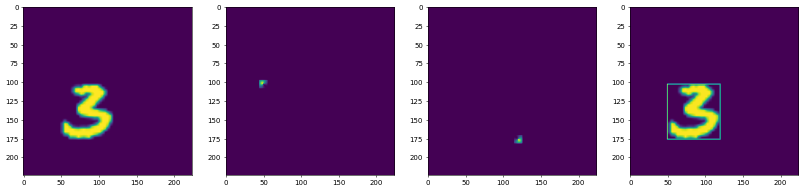

In [11]:
plt.figure(1,figsize = (20,5),dpi=50)
plt.subplot(141)
plt.imshow(train_X[0])
plt.subplot(142)
plt.imshow(train_y[0,0,:,:,0])
plt.subplot(143)
plt.imshow(train_y[0,1,:,:,0])
plt.subplot(144)
start_point = (true_y[0,1],true_y[0,0])
end_point = (true_y[0,3],true_y[0,2])
plt.imshow(cv2.rectangle(np.copy(train_X[0]),start_point,end_point,color=(255,255,0)))
plt.show()

In [12]:
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Reshape,Flatten,Input,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,concatenate
from tensorflow.keras.models import Model

In [13]:
train_X = np.repeat(train_X[..., np.newaxis], 3, -1)

In [14]:
class TopPool(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super(TopPool, self).__init__()

  def build(self,input_shape):
    pass

  def call(self, inputs):
    out=tf.expand_dims(tf.reduce_max(inputs,1),1)
    i=tf.constant(1)
    batch,h,w,c=inputs.get_shape().as_list()
    def cond(i,out):
        return i < h
    def body(i,out):
        d=tf.expand_dims(tf.reduce_max(inputs[:,i:,:,:],1),1)
        out=tf.concat((out,d),1)
        i = i + 1
        return i,out
    _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,None,w,c])])
    
    return out

class LeftPool(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super(LeftPool, self).__init__()

  def build(self,input_shape):
    pass

  def call(self, inputs):
    out=tf.expand_dims(tf.reduce_max(inputs,2),2)
    i=tf.constant(1)
    batch,h,w,c=inputs.get_shape().as_list()
    def cond(i,out):
        return i < w
    def body(i,out):
        d=tf.expand_dims(tf.reduce_max(inputs[:,:,i:,:],2),2)
        out=tf.concat((out,d),2)
        i = i + 1
        return i,out
    _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,h,None,c])])
    return out

class BottomPool(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super(BottomPool, self).__init__()

  def build(self,input_shape):
    pass

  def call(self, inputs):
    out=tf.expand_dims(tf.reduce_max(inputs,1),1)
    batch,h,w,c=inputs.get_shape().as_list()
    i=tf.constant(h-1)

    def cond(i,out):
        return i > 0
    def body(i,out):
        d=tf.expand_dims(tf.reduce_max(inputs[:,:i,:,:],1),1)
        out=tf.concat((d,out),1)
        i = i - 1
        return i,out
    _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,None,w,c])])
    return out
    
class RightPool(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super(RightPool, self).__init__()

  def build(self,input_shape):
    pass

  def call(self, inputs):
    out=tf.expand_dims(tf.reduce_max(inputs,2),2)
    batch,h,w,c=inputs.get_shape().as_list()
    i=tf.constant(w-1)

    def cond(i,out):
        return i > 0
    def body(i,out):
        d=tf.expand_dims(tf.reduce_max(inputs[:,:,:i,:],2),2)
        out=tf.concat((d,out),2)
        i = i - 1
        return i,out


    _,out = tf.while_loop(cond, body, [i,out],shape_invariants= [i.get_shape(), tf.TensorShape([batch,h,None,c])])
    return out


In [15]:
##### Checking the functioning of corner pooling layers #####
temp = np.random.randint(100,size=(2,5,5,3))
t = TopPool()(temp)
l = LeftPool()(temp)
ad = tf.keras.layers.Add()([t,l])
print(temp[0,:,:,0],t[0,:,:,0],l[0,:,:,0],ad[0,:,:,0])

[[59 92 93 61 37]
 [83  7 13 55 86]
 [92 11 22 18 16]
 [90 79 40 43 65]
 [65 57 96 91 44]] tf.Tensor(
[[92 92 96 91 86]
 [92 79 96 91 86]
 [92 79 96 91 65]
 [90 79 96 91 65]
 [65 57 96 91 44]], shape=(5, 5), dtype=int64) tf.Tensor(
[[93 93 93 61 37]
 [86 86 86 86 86]
 [92 22 22 18 16]
 [90 79 65 65 65]
 [96 96 96 91 44]], shape=(5, 5), dtype=int64) tf.Tensor(
[[185 185 189 152 123]
 [178 165 182 177 172]
 [184 101 118 109  81]
 [180 158 161 156 130]
 [161 153 192 182  88]], shape=(5, 5), dtype=int64)


In [16]:
img_size = 224
def build_model(start_neurons):
    input_layer = Input((img_size, img_size,3))
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    
    top_pool=Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    top_pool=TopPool()(top_pool)
    left_pool=Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    left_pool=LeftPool()(left_pool)
    top_left = tf.keras.layers.Add()([top_pool, left_pool])
    #top_left = concatenate([top_left,pre_TL_corner_pooling])
    top_left = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(top_left)

    skip_top_left = Conv2D(start_neurons * 1, (1, 1), activation="relu", padding="same")(uconv1)

    output_layer1 = tf.keras.layers.Add()([top_left, skip_top_left])
    output_layer1 = Conv2D(1, (3,3), padding="same", activation="sigmoid")(output_layer1)
    # output_layer1 = Conv2D(1, (1,1), padding="same", activation="sigmoid")(output_layer1)
    
    bottom_pool=Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    bottom_pool=BottomPool()(bottom_pool)
    right_pool=Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    right_pool=RightPool()(right_pool)
    bottom_right = tf.keras.layers.Add()([bottom_pool, right_pool])
    #top_left = concatenate([top_left,pre_TL_corner_pooling])
    bottom_right = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(bottom_right)

    skip_bottom_right = Conv2D(start_neurons * 1, (1, 1), activation="relu", padding="same")(uconv1)

    output_layer2 = tf.keras.layers.Add()([bottom_right, skip_bottom_right])
    output_layer2 = Conv2D(1, (3,3), padding="same", activation="sigmoid")(output_layer2)
    # output_layer2 = Conv2D(1, (1,1), padding="same", activation="sigmoid")(output_layer2)
    
    output_layers = [output_layer1,output_layer2]
    model = Model(input_layer,output_layers)
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model

model = build_model(8) 

In [17]:
# model.summary

In [18]:
train_X.shape

(2000, 224, 224, 3)

In [19]:
# import os

# TPU_worker = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_worker)
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)
# with strategy.scope():
#   input_layer = Input(shape=(img_size, img_size,3,))
#   output_layers = build_model(input_layer, 8)
#   model = Model(input_layer,output_layers)
#   model.compile(optimizer='adam',loss='binary_crossentropy')


In [20]:
import os
print(os.getcwd())

#################### set 0 for loading model from drive ###########
train_mode = 1
########## mounting Gdrive #######################
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# 30 epochs without Overfitting for sigma 5 with new model ( corner pooling integrated )

num_epochs = 40
model_name = "Unet-keras-epochs-" + str(num_epochs) + ".h5"
folder_location = '/content/gdrive/MyDrive/CornerNet-Unet-keras/'
model_location = folder_location + "/" + model_name


if(not os.path.isdir(folder_location)):
  os.mkdir(folder_location)


if (train_mode):
  model.fit(train_X,[train_y[:,0,:,:],train_y[:,1,:,:]],shuffle=True,epochs=num_epochs,validation_split=0.2,batch_size=8)
  model.save(model_location)
else:
  model = tf.keras.models.load_model(model_location,custom_objects={
      'TopPool':TopPool,
      'BottomPool':BottomPool,
      'LeftPool':LeftPool,
      'RightPool':RightPool
  })



Epoch 1/40
200/200 [==============================] - 154s 600ms/step - loss: 2.9760 - conv2d_22_loss: 1.7838 - conv2d_27_loss: 1.1922 - val_loss: 0.0422 - val_conv2d_22_loss: 0.0248 - val_conv2d_27_loss: 0.0174
Epoch 2/40
152/200 [=====================>........] - ETA: 26s - loss: 0.0141 - conv2d_22_loss: 0.0057 - conv2d_27_loss: 0.0084

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


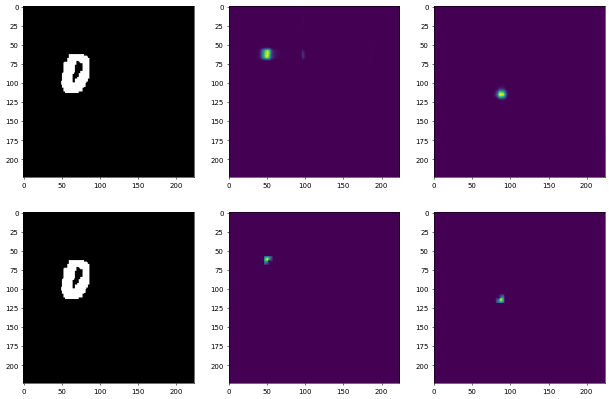

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


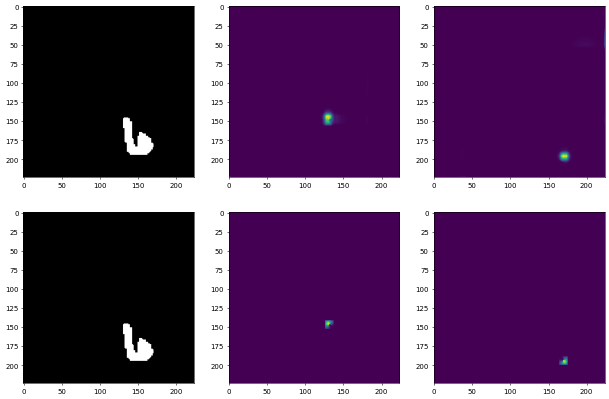

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


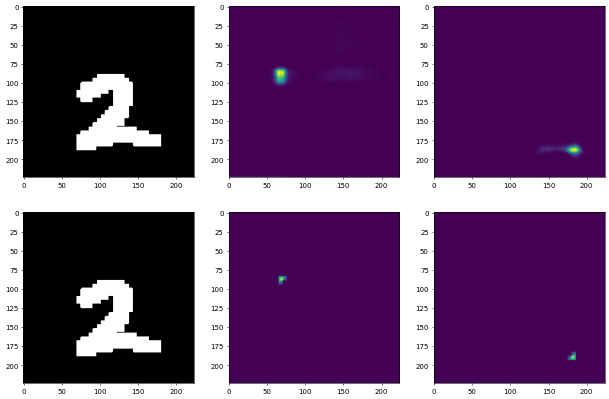

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


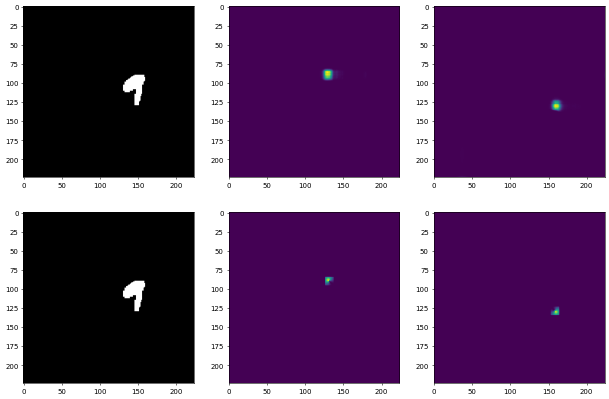

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


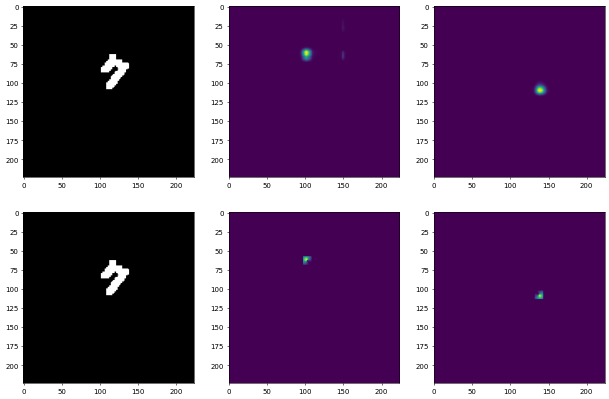

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


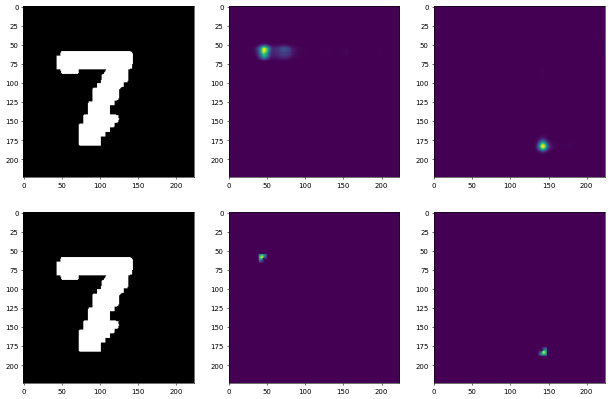

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


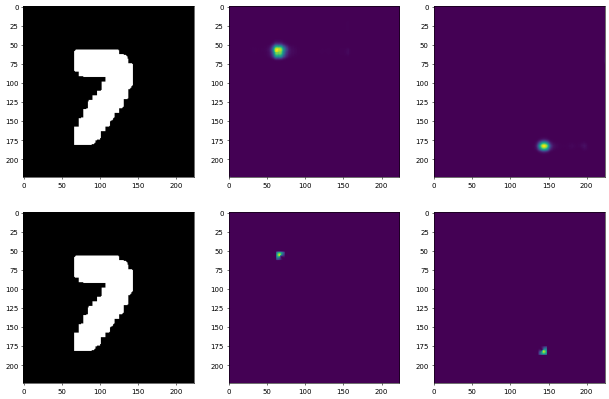

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


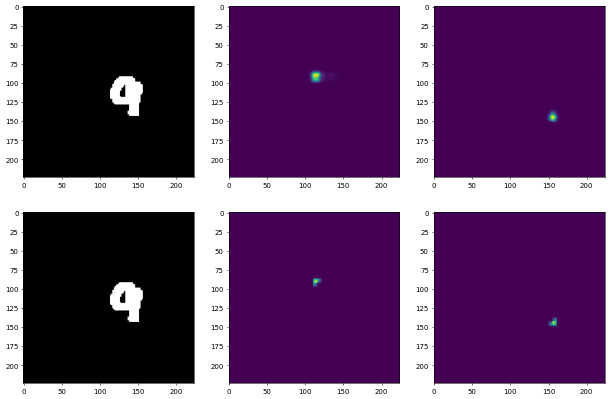

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


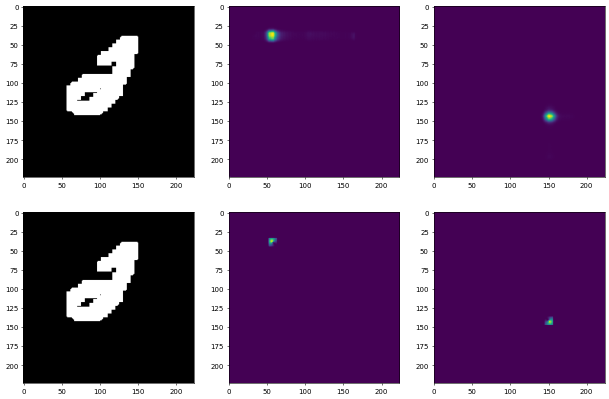

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


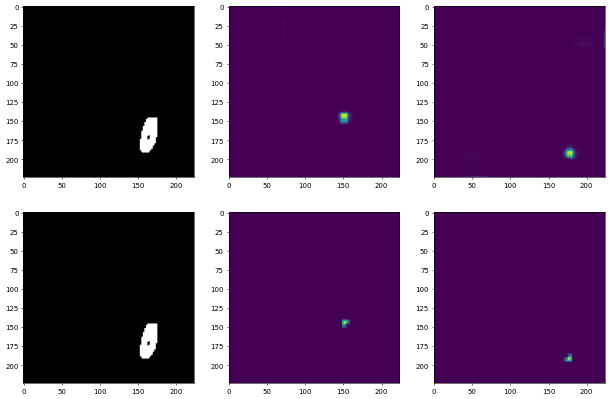

In [ ]:
save_patches = 0
patches_folder = folder_location + "/predicted_patches"
for i in range(10):
  r = np.random.randint(1,train_X.shape[0])
  pred = model.predict(np.array([train_X[r]]))
  plt.figure(1,figsize = (15,10),dpi=50)
  plt.subplot(231)
  plt.imshow(train_X[r])
  plt.subplot(232)
  plt.imshow(pred[0][0,:,:,0])
  plt.subplot(233)
  plt.imshow(pred[1][0,:,:,0])
  plt.subplot(234)
  plt.imshow(train_X[r])
  plt.subplot(235)
  plt.imshow(train_y[r,0,:,:,0])
  plt.subplot(236)
  plt.imshow(train_y[r,1,:,:,0])
  if(save_patches):
    if(not os.path.isdir(patches_folder)):
      os.mkdir(patches_folder)
    plt.savefig(patches_folder+'/'+str(i)+'.jpg')
  
  plt.show()
  

In [ ]:
os.listdir(folder_location)

['Sigma1',
 'Sigma5',
 'Rects_Sigma5',
 'unet_sigma5_epochs70.h5',
 'Updated_patch_Sigma5',
 'Updated_patch_Rects_Sigma5',
 'unet_sigma5_updated_patch_epochs50.h5',
 'Updated_Corner_Pooling_Sigma5',
 'Updated_patch_Corner_pooling_Sigma5',
 'Updated_Corner_pooling_Rects_Sigma5',
 'unet_sigma5_updated_corner_pooling_epochs30.h5',
 'unet_sigma5_updated_corner_pooling_epochs40.h5',
 'person-bounding-box-v1.record']

In [ ]:
train_y.shape

(2000, 2, 224, 224, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


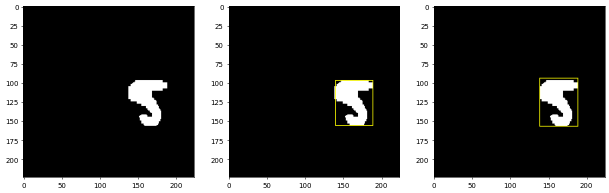

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


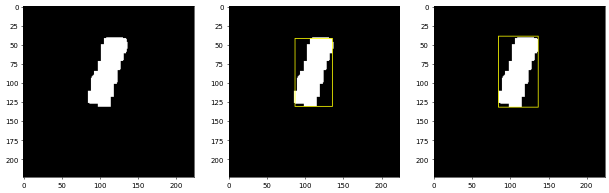

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


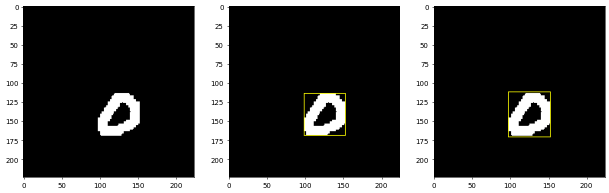

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


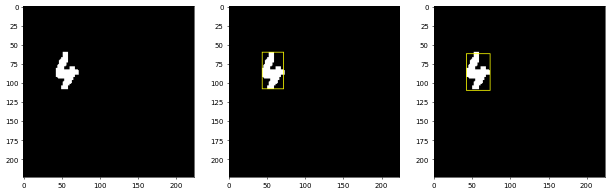

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


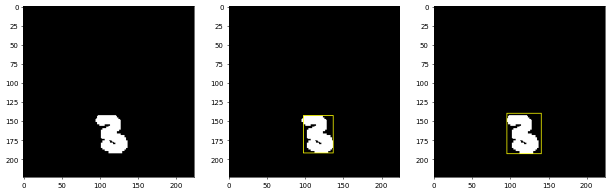

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


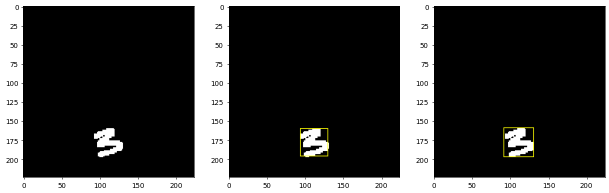

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


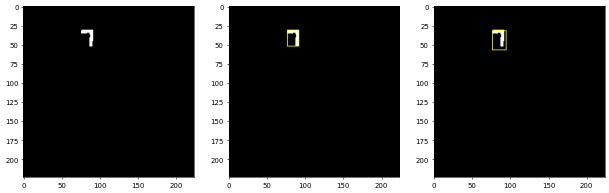

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


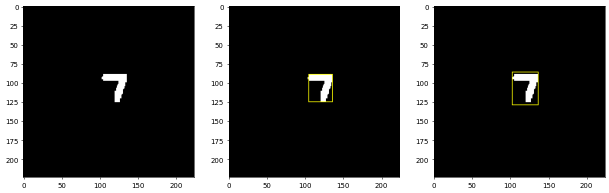

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


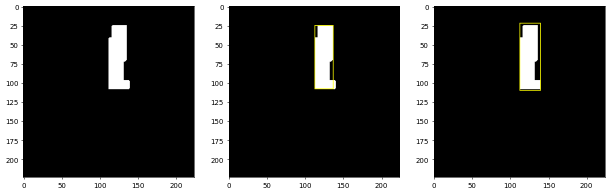

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


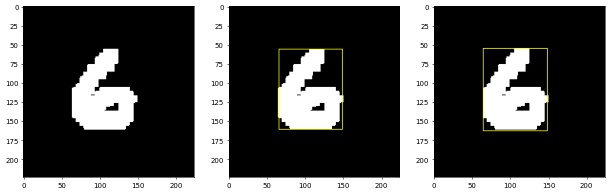

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


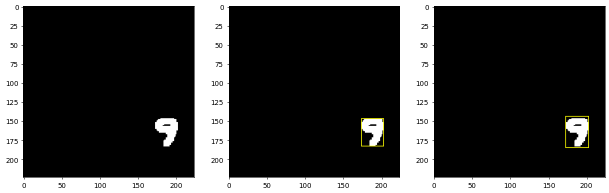

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


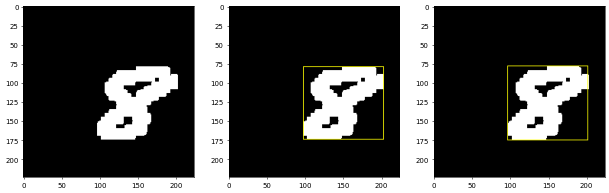

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


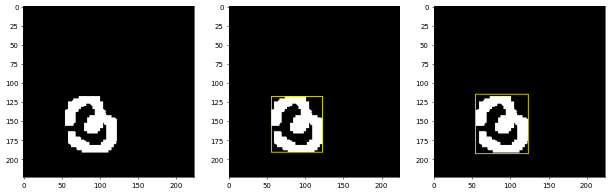

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


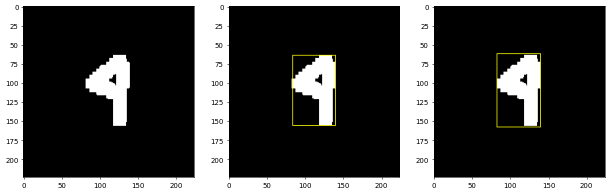

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


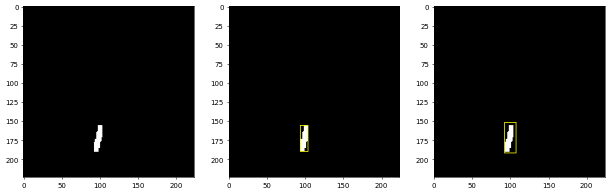

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


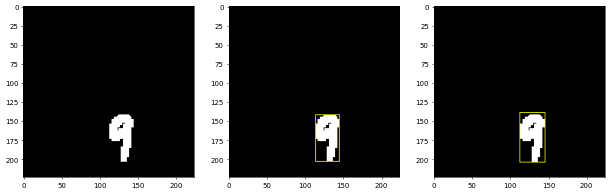

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


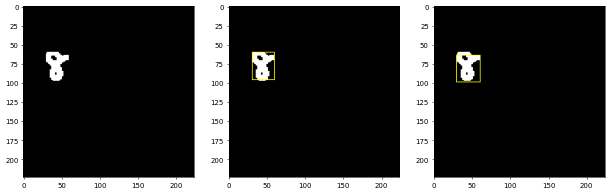

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


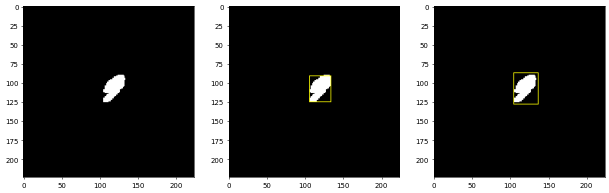

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


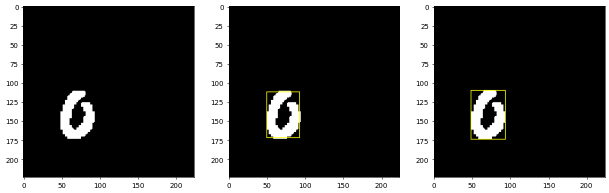

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


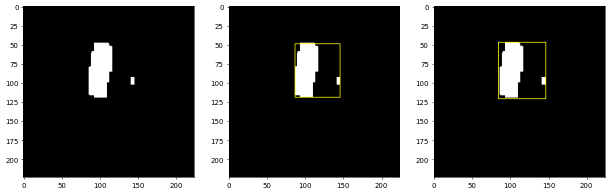

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


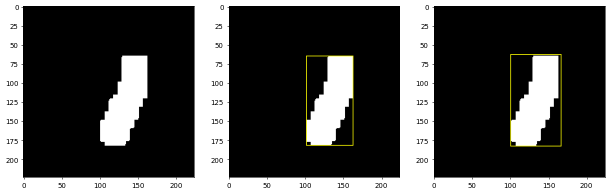

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


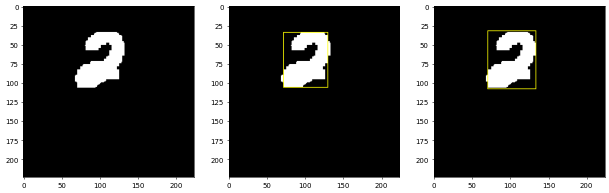

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


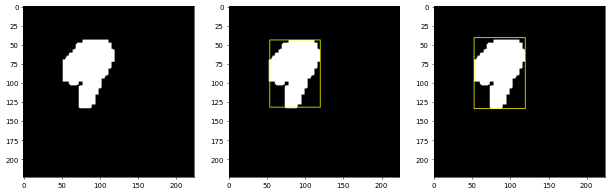

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


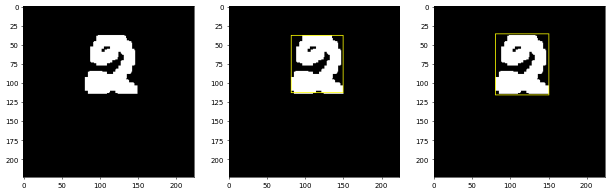

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


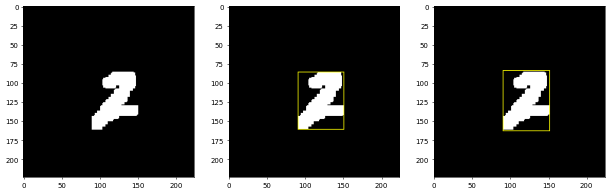

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


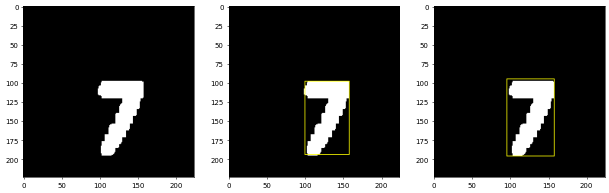

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


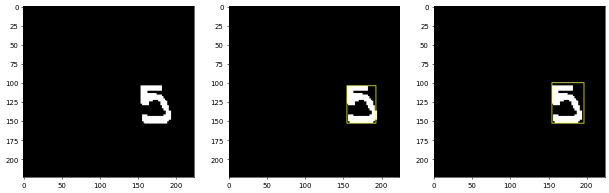

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


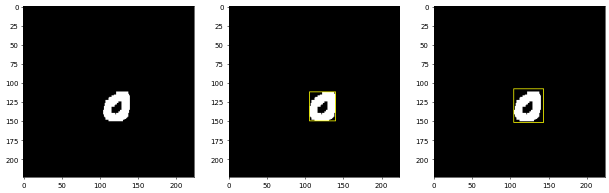

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


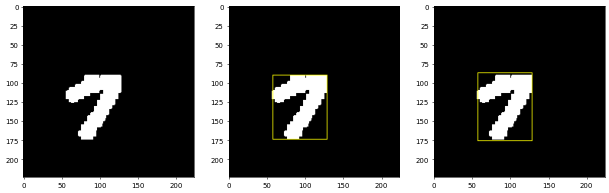

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


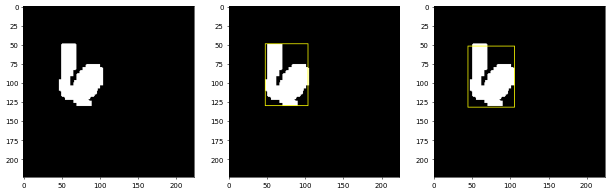

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


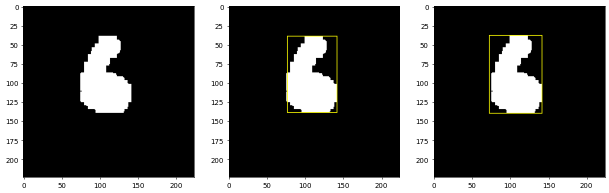

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


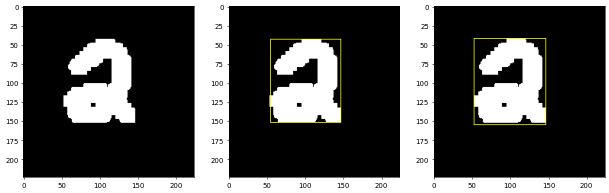

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


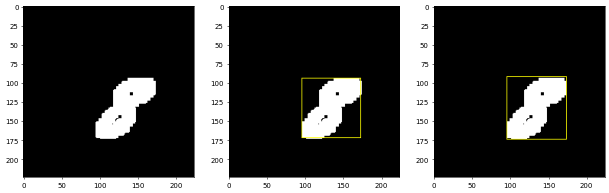

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


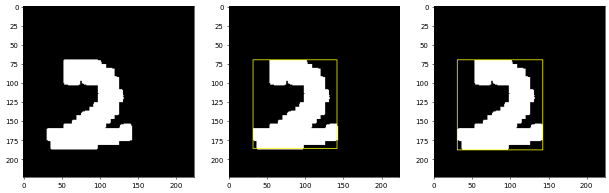

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


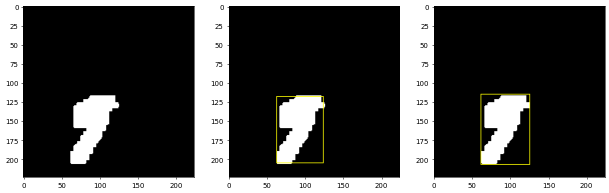

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


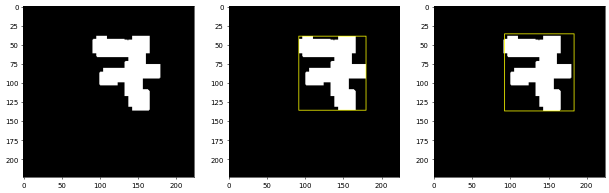

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


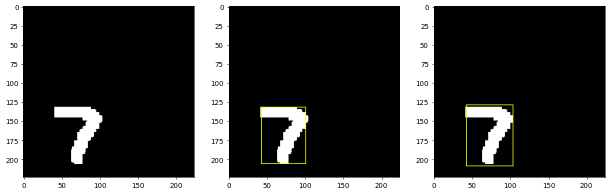

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


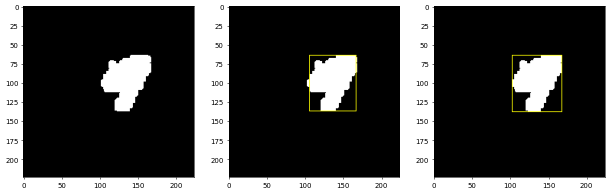

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


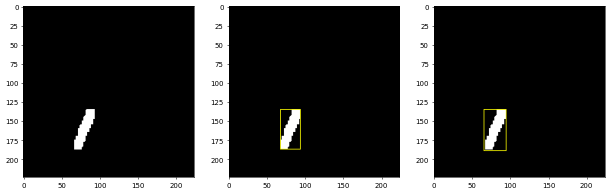

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


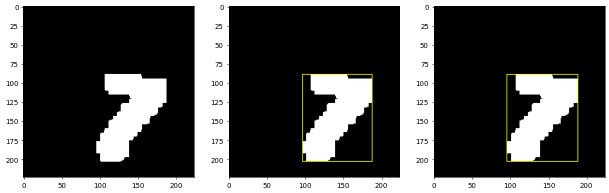

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


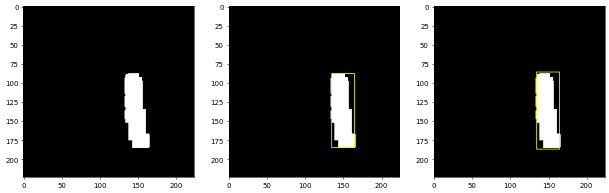

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


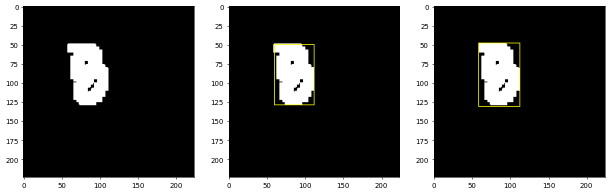

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


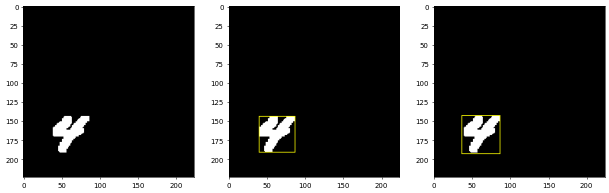

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


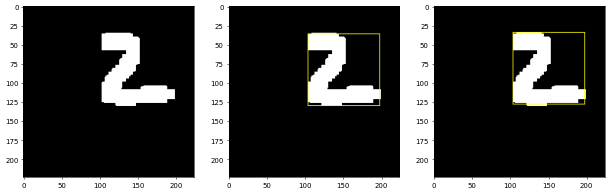

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


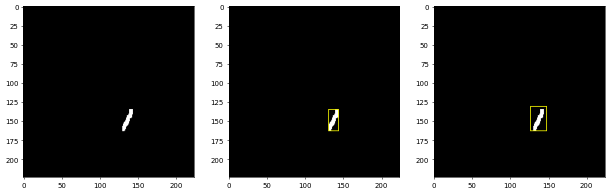

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


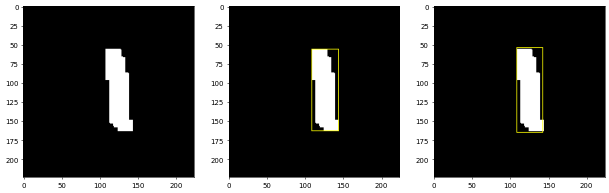

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


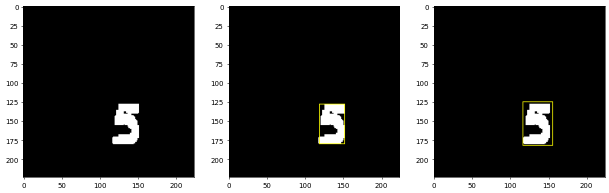

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


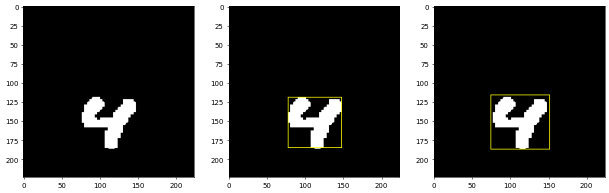

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


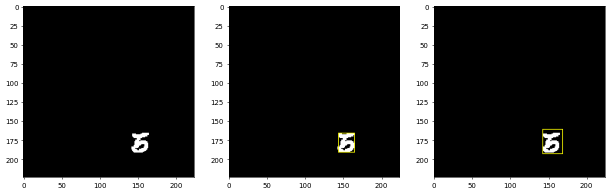

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


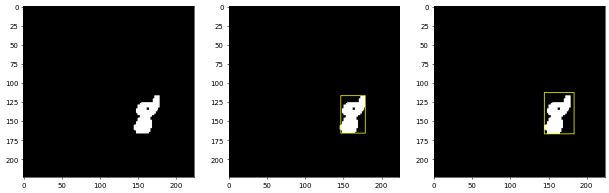

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


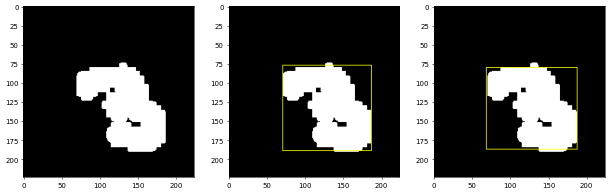

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


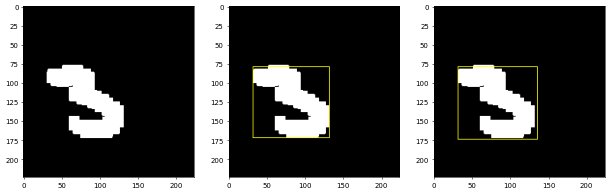

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


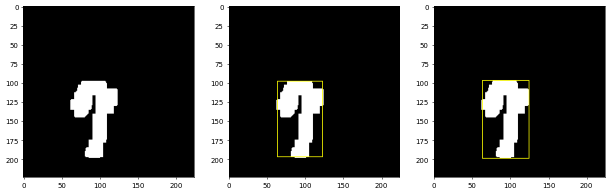

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


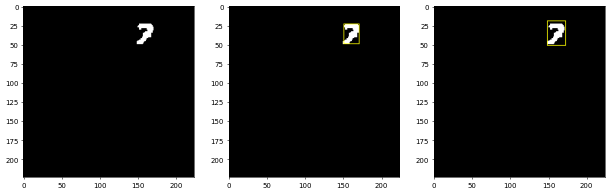

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


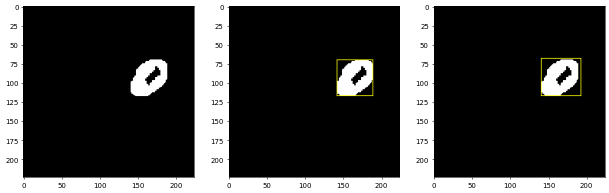

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


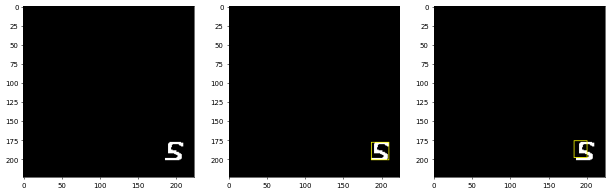

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


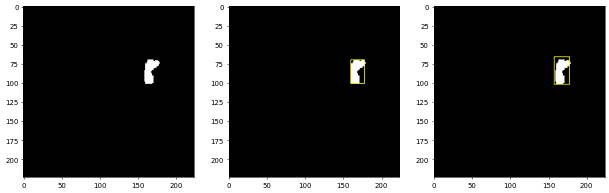

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


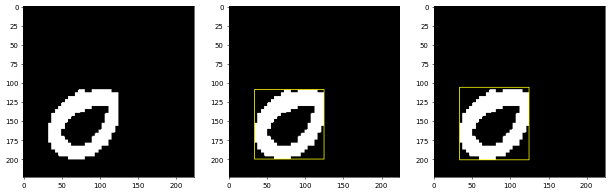

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


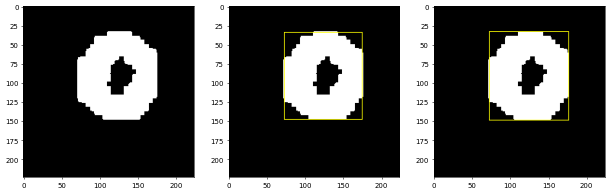

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


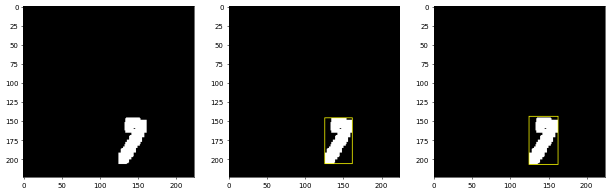

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


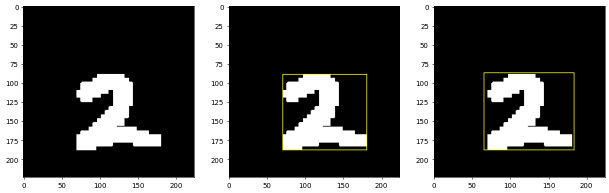

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


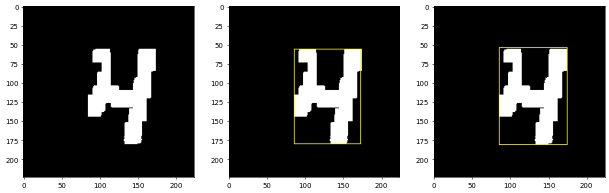

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


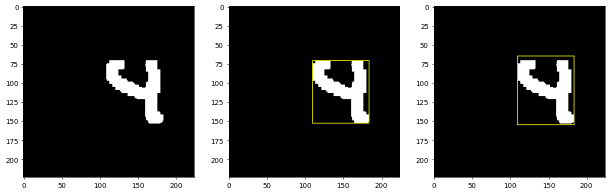

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


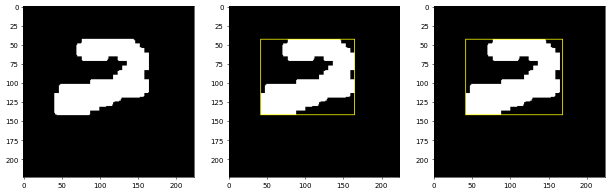

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


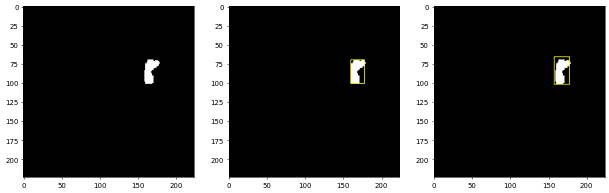

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


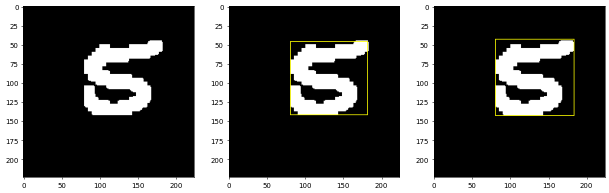

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


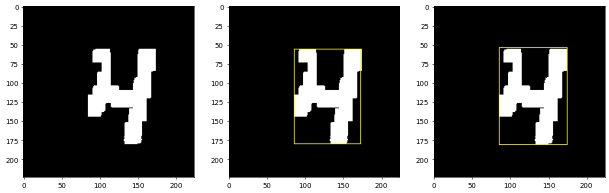

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


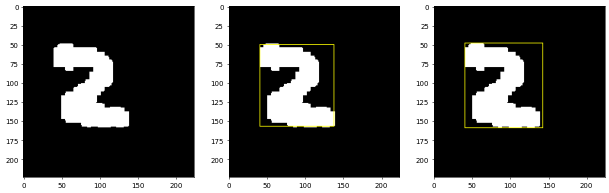

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


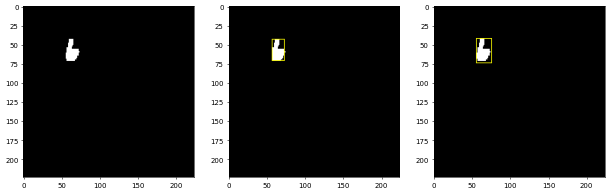

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


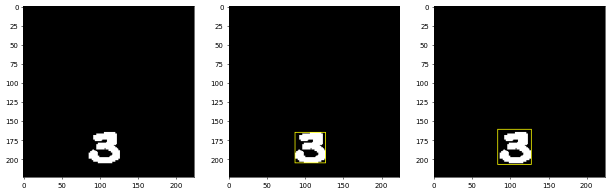

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


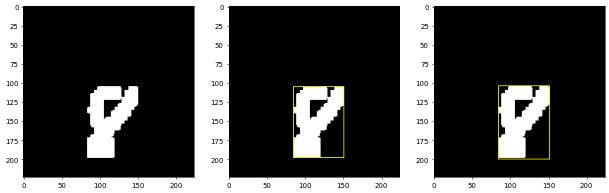

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


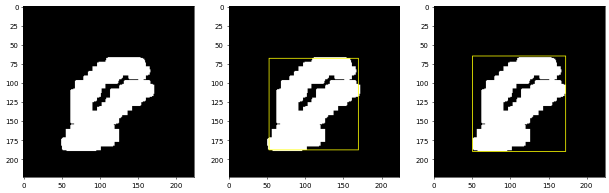

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


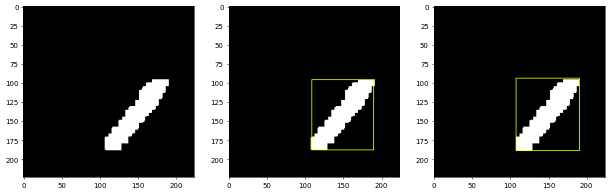

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


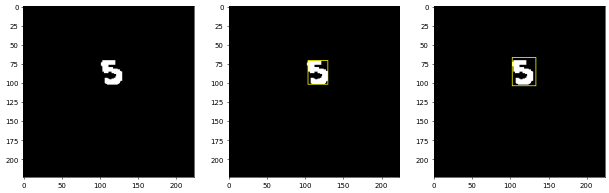

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


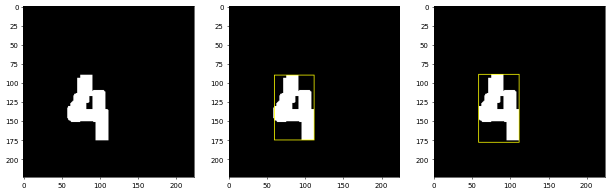

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


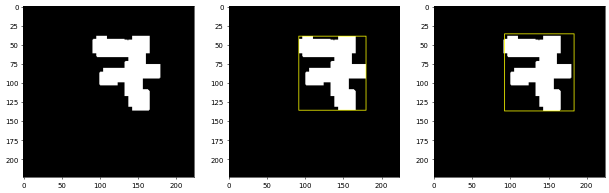

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


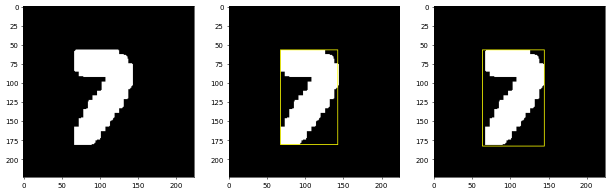

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


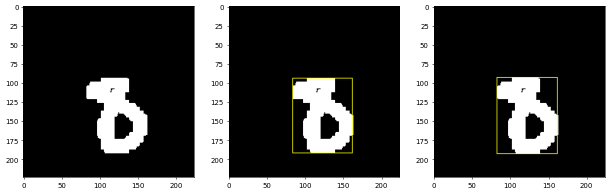

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


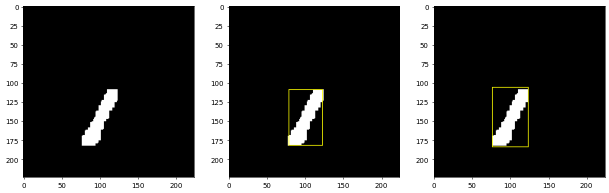

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


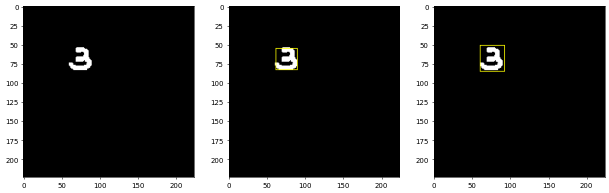

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


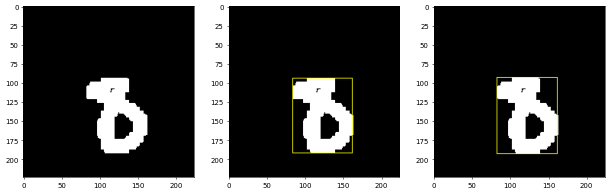

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


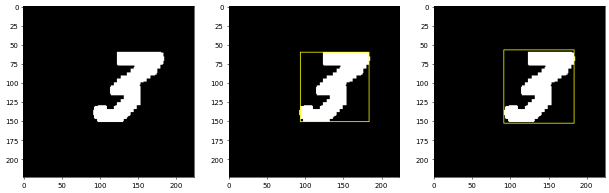

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


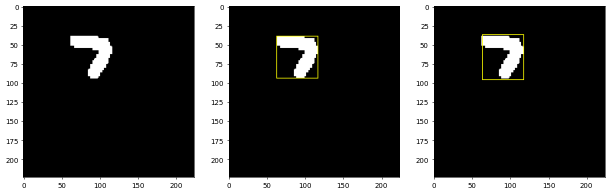

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


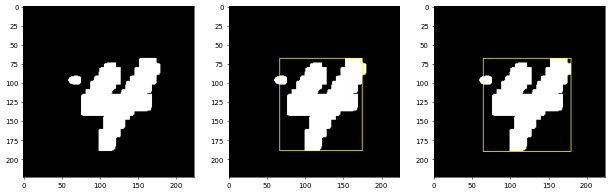

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


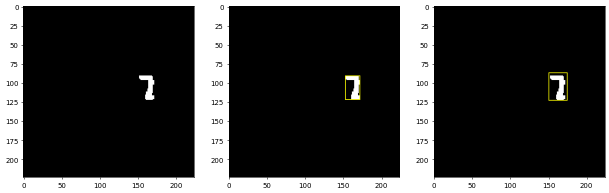

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


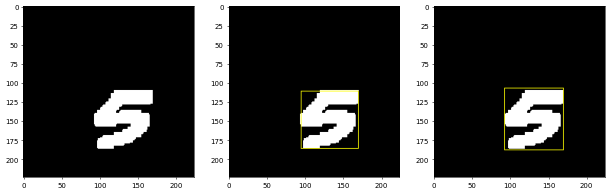

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


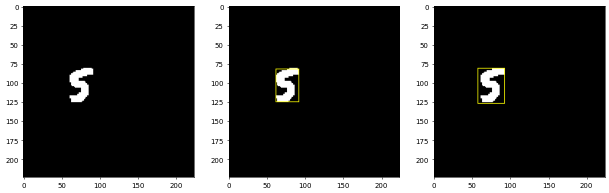

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


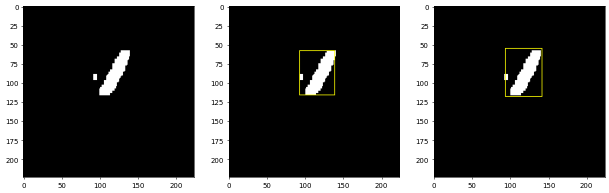

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


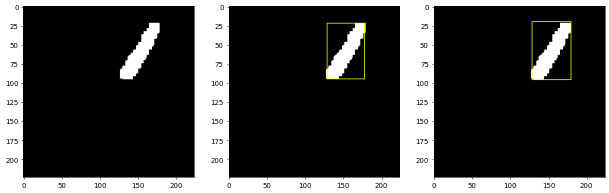

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


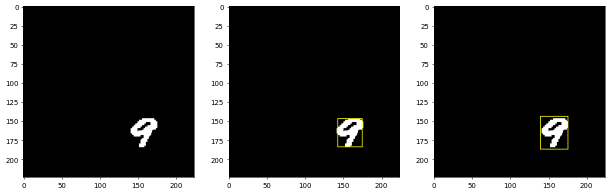

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


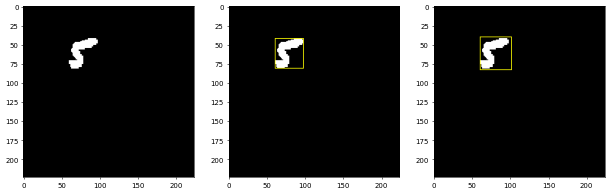

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


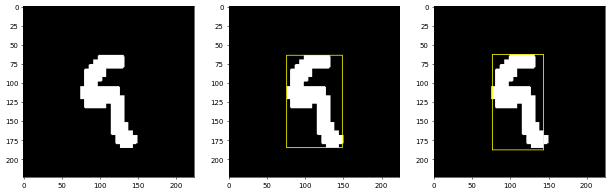

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


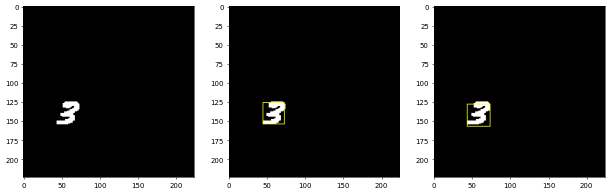

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


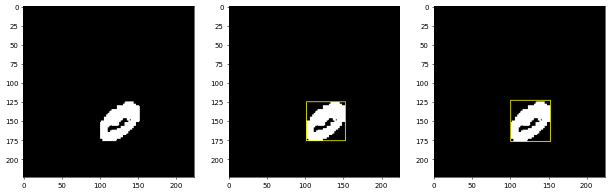

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


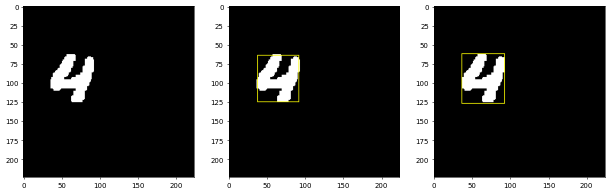

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


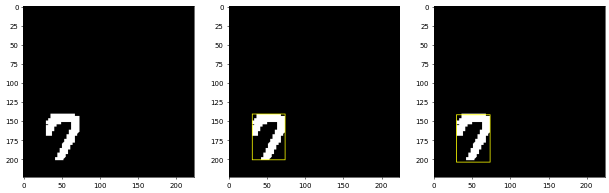

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


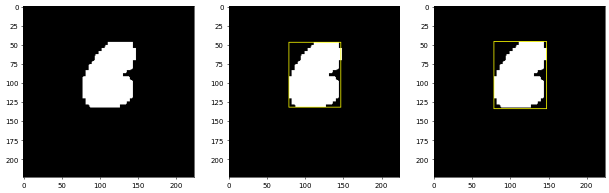

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


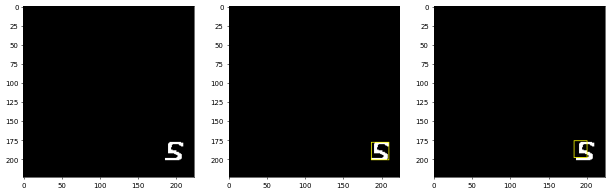

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


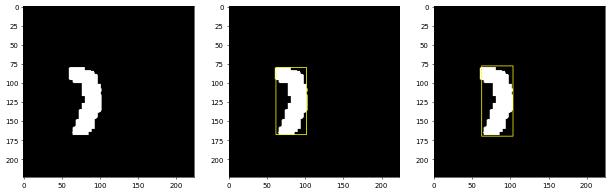

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


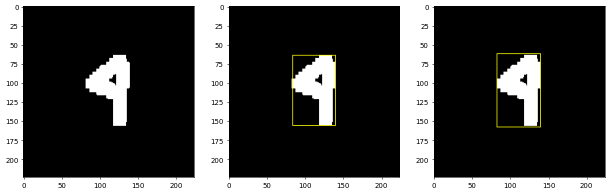

In [ ]:
save_rectangles = 1
rectangles_folder = folder_location + "/predicted_rectangles"
for i in range(10):
  r = np.random.randint(1,train_X.shape[0])
  pred = model.predict(np.array([train_X[r]]))
  plt.figure(1,figsize = (15,5),dpi=50)
  plt.subplot(131)
  plt.imshow(train_X[r])
  plt.subplot(132)
  plt.imshow(cv2.rectangle(np.copy(train_X[r]),(true_y[r,1],true_y[r,0]),(true_y[r,3],true_y[r,2]),color=(255,255,0)))
  plt.subplot(133)
  
  xmin,ymin = np.unravel_index(np.argmax(pred[0][0, :, :,0]), (imgSize, imgSize))
  xmax,ymax = np.unravel_index(np.argmax(pred[1][0, :, :,0]), (imgSize, imgSize))
  plt.imshow(cv2.rectangle(np.copy(train_X[r]),(ymin,xmin),(ymax,xmax),color=(255,255,0)))
  
  if(save_rectangles):
    if(not os.path.isdir(rectagles_folder)):
      os.mkdir(rectangles_folder)
    plt.savefig(rectangles_folder+'/'+str(i)+'.jpg')
  plt.show()